In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

In [3]:
import nltk
from nltk.corpus import wordnet
import random

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    if word in synonyms:
        synonyms.remove(word)  # Remove the original word from synonyms
    return list(synonyms)

def synonym_replacement(sentence, n):
    words = nltk.word_tokenize(sentence)
    replaced_sentence = words[:]
    words_indexes = list(range(len(words)))
    random.shuffle(words_indexes)

    replaced = 0
    for i in words_indexes:
        synonyms = get_synonyms(words[i])
        if synonyms:
            synonym = random.choice(synonyms)
            replaced_sentence[i] = synonym
            replaced += 1
            if replaced >= n:  # Replace up to n words
                break

    return ' '.join(replaced_sentence)

# Example usage
sentence = "The quick brown fox jumps over the lazy dog"
replaced_sentence = synonym_replacement(sentence, 3)  # Replace up to 3 words
print("Original sentence:", sentence)
print("Sentence after synonym replacement:", replaced_sentence)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Original sentence: The quick brown fox jumps over the lazy dog
Sentence after synonym replacement: The quick Brown_University fox start all_over the lazy dog


In [4]:
from transformers import MarianMTModel, MarianTokenizer

def back_translate(text, model_name_src_to_tgt, model_name_tgt_to_src):
    # Initialize the tokenizer and model for source to target language
    tokenizer_src_to_tgt = MarianTokenizer.from_pretrained(model_name_src_to_tgt)
    model_src_to_tgt = MarianMTModel.from_pretrained(model_name_src_to_tgt)

    # Translate from source to target language
    translated = model_src_to_tgt.generate(**tokenizer_src_to_tgt(text, return_tensors="pt", padding=True))

    # Decode the translated text
    tgt_text = tokenizer_src_to_tgt.decode(translated[0], skip_special_tokens=True)

    # Initialize the tokenizer and model for target to source language
    tokenizer_tgt_to_src = MarianTokenizer.from_pretrained(model_name_tgt_to_src)
    model_tgt_to_src = MarianMTModel.from_pretrained(model_name_tgt_to_src)

    # Translate back from target to source language
    back_translated = model_tgt_to_src.generate(**tokenizer_tgt_to_src(tgt_text, return_tensors="pt", padding=True))

    # Decode the back-translated text
    src_text = tokenizer_tgt_to_src.decode(back_translated[0], skip_special_tokens=True)

    return src_text

# Example usage
text = "The quick brown fox jumps over the lazy dog"
text2 = "A hungry man wants to eat a pizza from the local takeaway"
model_name_src_to_tgt = "Helsinki-NLP/opus-mt-en-fr"
model_name_tgt_to_src = "Helsinki-NLP/opus-mt-fr-en"

back_translated_text = back_translate(text2, model_name_src_to_tgt, model_name_tgt_to_src)
print("Original text:", text2)
print("Back-translated text:", back_translated_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Original text: A hungry man wants to eat a pizza from the local takeaway
Back-translated text: A hungry man wants to eat a pizza from the corner to take away


In [5]:
import random
import string

def inject_noise(sentence, noise_type='all', noise_level=0.1):
    """
    Injects noise into a given sentence. The type of noise can be specified.
    - sentence: The input sentence to which noise will be added.
    - noise_type: The type of noise to add ('insert', 'delete', 'substitute', or 'all').
    - noise_level: Fraction of characters to alter (between 0 and 1).
    """
    # Function to insert noise: Randomly adds a character within a word
    def insert_noise(word):
        if len(word) > 1:  # Avoid inserting into very short words
            insert_pos = random.randint(1, len(word)-1)  # Avoid inserting at the first position
            insert_char = random.choice(string.ascii_lowercase)
            return word[:insert_pos] + insert_char + word[insert_pos:]
        return word

    # Function to delete noise: Randomly removes a character from a word
    def delete_noise(word):
        if len(word) > 1:
            delete_pos = random.randint(0, len(word)-1)
            return word[:delete_pos] + word[delete_pos+1:]
        return word

    # Function to substitute noise: Replaces a character with a random character
    def substitute_noise(word):
        if len(word) > 1:
            substitute_pos = random.randint(0, len(word)-1)
            substitute_char = random.choice(string.ascii_lowercase)
            return word[:substitute_pos] + substitute_char + word[substitute_pos+1:]
        return word

    noise_functions = {
        'insert': insert_noise,
        'delete': delete_noise,
        'substitute': substitute_noise
    }

    words = sentence.split()
    num_words_to_change = max(1, int(len(words) * noise_level))  # Ensure at least one word is changed
    words_to_change = random.sample(words, num_words_to_change)

    for i, word in enumerate(words):
        if word in words_to_change:
            if noise_type == 'all':
                # Apply a random noise function
                noise_func = random.choice(list(noise_functions.values()))
                words[i] = noise_func(word)
            else:
                # Apply the specified noise function
                words[i] = noise_functions[noise_type](word)

    return ' '.join(words)

# Example usage
sentence = "The quick brown fox jumps over the lazy dog"
print("Original sentence:", sentence)
print("With insertion noise:", inject_noise(sentence, 'insert'))
print("With deletion noise:", inject_noise(sentence, 'delete'))
print("With substitution noise:", inject_noise(sentence, 'substitute'))
print("With random noise of all types:", inject_noise(sentence, 'all'))

Original sentence: The quick brown fox jumps over the lazy dog
With insertion noise: The quick brown fox jyumps over the lazy dog
With deletion noise: The quick brown fo jumps over the lazy dog
With substitution noise: The qzick brown fox jumps over the lazy dog
With random noise of all types: The quick brown fox jumps over the hazy dog


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
import torch

file_path = "./dontpatronizeme_pcl.tsv"
train_filepath = "./train_semeval_parids-labels.csv"
dev_filepath = "./dev_semeval_parids-labels.csv"

df = pd.read_csv(file_path, sep='\t', header=None, names=['id', 'paragraph-id', 'keyword', 'countrycode', "paragraph", "label"])
df_filtered = df[df['paragraph'].notna()]

# labels = [[0,1] if int(x)<=1 else [1,0] for x in df_filtered['label']]

# labels = np.array(labels)

# df_filtered['contains_pcl'] = df_filtered['label'].apply(lambda x: np.array([0,1]) if int(x) <= 1 else np.array([1,0])) # [True, False]

train_df = pd.read_csv(train_filepath)
dev_df = pd.read_csv(dev_filepath)

train_data = df_filtered[df_filtered['id'].isin(train_df['par_id'])]
dev_data = df_filtered[df_filtered['id'].isin(dev_df['par_id'])]

# get indexes of labels 0 and 1
train_data_0 = train_data[train_data['label'] <= 1]
train_data_1 = train_data[train_data['label'] > 1]
# get 10% of the training data indexes

desired_num_samples = len(train_data_0)  # Number of samples in the majority class
minority_class_upsampled = resample(train_data_1,
                                    replace=True,     # sample with replacement
                                    n_samples=desired_num_samples,    # to match majority class
                                    random_state=123) # reproducible results

# Combine the upsampled minority class with the majority class
train_data_balanced = pd.concat([train_data_0, minority_class_upsampled])

# Shuffle the combined dataset
train_data_shuffled = shuffle(train_data_balanced, random_state=42)

dev_data_shuffled = shuffle(dev_data, random_state=42)

X_train = train_data_shuffled['paragraph'].to_numpy()
X_dev = dev_data_shuffled['paragraph'].to_numpy()

y_train = np.array([[0,1] if int(x) <= 1 else [1,0] for x in train_data_shuffled['label']])
y_dev = np.array([[0,1] if int(x) <= 1 else [1,0] for x in dev_data_shuffled['label']])

print(X_train.shape)
print(X_dev.shape)


# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the dataset into training (80%) and validation (20%) sets
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

(15162,)
(2093,)


In [7]:
len(train_data_shuffled[train_data_shuffled['label'] > 1])

7581

In [8]:
train_data_shuffled

,id,paragraph-id,keyword,countrycode,paragraph,label
4077,4078,@@4523589,disabled,jm,The local organisation which represents the vi...,0
82,83,@@4672144,homeless,pk,The demographics of Pakistan and India are ver...,3
963,964,@@9193903,disabled,us,"To make room on the 40-man roster , Ryan Vogel...",0
6652,6653,@@18700654,vulnerable,ph,The climate accord to which the Philippines ha...,3
6949,6950,@@15823756,homeless,ie,From sleeping rough to becoming a published au...,3
...,...,...,...,...,...,...
5727,5728,@@21900778,migrant,ng,""" When we arrived at the spot , we found an in...",0
6040,6041,@@8979827,poor-families,za,A : They are taking inner-city kids of poor fa...,3
5950,5951,@@14127194,hopeless,nz,I also wrote to Craig Foss and told him that h...,0
961,962,@@14978868,poor-families,ng,This is not a scarce case in Yemen as a number...,1


In [9]:
dev_data_shuffled

,id,paragraph-id,keyword,countrycode,paragraph,label
10056,10057,@@4197415,poor-families,ca,Darte acknowledged cutting back to the Windsor...,0
9650,9651,@@25216962,migrant,bd,UNITED States President Donald Trump has defen...,0
9119,9120,@@22467955,immigrant,ca,Saraswat said most immigrants have unique livi...,0
8504,8505,@@10179731,hopeless,pk,He said some elements were bent upon spreading...,0
1282,1283,@@3208839,refugee,ph,""" Stateless "" is the story of a forgotten grou...",4
...,...,...,...,...,...,...
9977,9978,@@13589752,homeless,in,One response to marital infidelity is divorce ...,0
9384,9385,@@1955909,homeless,tz,Various other areas have been experiencing exc...,0
9423,9424,@@18374692,hopeless,ca,Chris Selley : Maybe liquor retail in Ontario ...,0
9594,9595,@@1065878,hopeless,us,Robin Wauters is the European Editor of The Ne...,0


In [10]:
labels = torch.tensor(y_train)
labels

tensor([[0, 1],
        [1, 0],
        [0, 1],
        ...,
        [0, 1],
        [0, 1],
        [0, 1]])

In [10]:
from transformers import RobertaTokenizer, BertTokenizer


# Load the BERT tokenizer.
print('Loading RoBERTa tokenizer...')
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
'''
Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]
'''

Loading RoBERTa tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

'\nOriginal:  Our friends won\'t buy this analysis, let alone the next one we propose.\nTokenized:  [\'our\', \'friends\', \'won\', "\'", \'t\', \'buy\', \'this\', \'analysis\', \',\', \'let\', \'alone\', \'the\', \'next\', \'one\', \'we\', \'propose\', \'.\']\nToken IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]\n'

In [16]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


In [17]:
import wandb

sweep_config = {
    'method': 'random',  # or 'grid'
    'metric': {
      'name': 'val_f1_score',
      'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [1e-4, 2e-5, 5e-6]
        },
        'batch_size': {
            'values': [32]
        },
        'epochs': {
            'values': [5]
        },
        'warmup_percentage': {
            'values': [0.05]
        },
        'loss_function': {
            'values': ['bce_cross_entropy', 'focal']
        }
    }
}

sweep_defaults = {
    'learning_rate': 5e-6,
    'batch_size': 16,
    'epochs': 2,
    'warmup_percentage': 0.05,
    'loss_function': 'cross_entropy'  # Default loss function
}

sweep_id = wandb.sweep(sweep_config)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

In [24]:
import torch
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X_train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_train)

# Print sentence 0, now as a list of IDs.
print('Original: ', X_train[0])
print('Token IDs:', input_ids[0])
print('Attention Mask:', attention_masks)
print('labels', labels[0])

Original:  The local organisation which represents the visually impaired has heaped scorn on the Government 's commitment to implement many of the Vision 2030 initiatives that have been designed to improve the quality of life of disabled persons .
Token IDs: tensor([    0,   133,   400,  6010,    61,  3372,     5, 21545, 15241,    34,
           37, 14677, 38430,    15,     5,  1621,   128,    29,  2720,     7,
         5731,   171,     9,     5, 13396, 12060,  5287,    14,    33,    57,
         1887,     7,  1477,     5,  1318,     9,   301,     9,  6242,  5151,
          479,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,    

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, paragraphs, labels, apply_augmentation=False, augmentation_type=None):
        """
        Args:
            paragraphs: Tensor of input ids.
            attention_masks: Tensor of attention masks.
            labels: Tensor of labels.
            apply_augmentation (bool): Flag to control the application of augmentation.
        """
        self.paragraphs = paragraphs
        self.labels = labels
        self.apply_augmentation = apply_augmentation
        self.augmentation_type = augmentation_type

        input_ids = []
        attention_masks = []

        if not apply_augmentation:
          for para in paragraphs:
            encoded_dict = tokenizer.encode_plus(
                        para,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
            input_ids.append(encoded_dict['input_ids'])
            # Add the encoded sentence to the list.
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

          self.input_ids = torch.cat(input_ids, dim=0)
          self.attention_mask = torch.cat(attention_masks, dim=0)



    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        paragraph = self.paragraphs[idx]
        label = self.labels[idx]

        if self.apply_augmentation:
            # Apply data augmentation here
            paragraph = self.augment(paragraph)

            encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 300,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
            input_id = encoded_dict['input_ids'][0]
            attention_mask = encoded_dict['attention_mask'][0]

            return input_id, attention_mask, label
        else:
          return self.input_ids[idx], self.attention_mask[idx], label


    def augment(self, paragraph):
        if self.augmentation_type == 'synonym_replacement':
            # Apply synonym replacement
            paragraph = synonym_replacement(paragraph, 3)
        if self.augmentation_type == 'back_translation':
            # Apply back translation
            paragraph = back_translate(paragraph, model_name_src_to_tgt, model_name_tgt_to_src)
        if self.augmentation_type == 'noise_injection':
            # Apply noise injection
            paragraph = inject_noise(paragraph, 'all', 0.1)
        return paragraph

In [26]:
import torch
train_size = int(0.9 * len(X_train))
val_size = len(X_train) - train_size

# Generate a permutation of indices and then split according to train_size
indices = torch.randperm(len(X_train)).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Use these indices to create the tensors for the training and validation sets
train_input_ids = X_train[train_indices]
train_attention_masks = attention_masks[train_indices]
train_labels = labels[train_indices]

val_input_ids = X_train[val_indices]
val_attention_masks = attention_masks[val_indices]
val_labels = labels[val_indices]

# Now you have split tensors and can create datasets as needed
train_dataset = CustomDataset(train_input_ids, train_labels, apply_augmentation=True, augmentation_type='noise_injection')
val_dataset = CustomDataset(val_input_ids, val_labels, apply_augmentation=False)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import wandb
# WANDB PARAMETER
def ret_dataloader():
    batch_size = wandb.config.batch_size
    # batch_size = 16
    print('batch_size = ', batch_size)
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )

    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    return train_dataloader,validation_dataloader

In [14]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig

def ret_model():

    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels = 2,
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )
    # model = RobertaForSequenceClassification.from_pretrained(
    #     "roberta-base",
    #     num_labels = 2,
    #     output_attentions = False, # Whether the model returns attentions weights.
    #     output_hidden_states = False, # Whether the model returns all hidden-states.
    # )

    return model

In [15]:
def ret_optim(model):
    print('Learning_rate = ',wandb.config.learning_rate )
    optimizer = AdamW(model.parameters(),
                      lr = wandb.config.learning_rate,
                      eps = 1e-8
                    )
    return optimizer


In [18]:
from transformers import get_linear_schedule_with_warmup

def ret_scheduler(train_dataloader,optimizer):
    epochs = wandb.config.epochs
    print('epochs = ', epochs)
    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    wp = wandb.config.warmup_percentage
    print('warmup percentage', wp)
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = wp * total_steps,
                                                num_training_steps = total_steps)
    return scheduler

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def dice_loss(input, target, smooth=1):
    input_flat = input.view(-1)
    target_flat = target.view(-1)
    intersection = (input_flat * target_flat).sum()
    return 1 - ((2. * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth))

def focal_loss(input, target, alpha=0.25, gamma=2.0):
    bce_loss = F.binary_cross_entropy_with_logits(input, target, reduction='none')
    pt = torch.exp(-bce_loss) # Prevents nans when probability 0
    f_loss = alpha * (1-pt)**gamma * bce_loss
    return f_loss.mean()

def ret_loss():
    loss_type = wandb.config.loss_function
    if loss_type == 'bce_cross_entropy':
        return torch.nn.BCEWithLogitsLoss()
    elif loss_type == 'focal':
        # Adjust alpha and gamma as needed based on your config
        alpha = wandb.config.get('focal_alpha', 0.25)
        gamma = wandb.config.get('focal_gamma', 2.0)
        return lambda input, target: focal_loss(input, target, alpha=alpha, gamma=gamma)
    elif loss_type == 'dice':
        return lambda input, target: dice_loss(input, target)
    else:
        raise ValueError(f"Unsupported loss function: {loss_type}")


In [69]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)


import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [70]:
!pip install torchmetrics

In [22]:
import random
import numpy as np
from torchmetrics import Precision, F1Score, Accuracy
from torch.nn import functional as F
import torch
import gc

# Initialize metrics
# Assuming you're working on a binary classification problem
task = 'binary' # Use 'multiclass' for multi-class classification

# Initialize metrics with the task parameter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# precision = Precision(num_classes=2, average='macro', task=task).to(device)
# f1_score = F1Score(num_classes=2, average='macro', task=task).to(device)
accuracy = Accuracy(num_classes=2, average='macro', task=task).to(device)

    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.
def train():

    wandb.init()
    losses = []
    val_losses = []

    # print(device)
    model = ret_model()
    model.to(device)
    #wandb.init(config=sweep_defaults)
    train_dataloader, validation_dataloader = ret_dataloader()
    optimizer = ret_optim(model)
    scheduler = ret_scheduler(train_dataloader,optimizer)
    criterion = ret_loss()


    #print("config ",wandb.config.learning_rate, "\n",wandb.config)
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    #torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    epochs = wandb.config.epochs
    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.
        # precision.reset()
        # f1_score.reset()

        # print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        # print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0
        # total_train_precision = 0
        # total_train_f1 = 0

        # all_train_logits = []
        # all_train_labels = []

        total_TP = 0
        total_FP = 0
        total_FN = 0
        total_TN = 0

        # Put the model into training mode. Don't be mislead--the call to
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            # print(b_labels)
            # print(b_input_ids)
            # print(b_input_ids.shape)
            outputs = model(b_input_ids,
                                attention_mask=b_input_mask)

            logits = outputs.logits
            # print(logits)

            loss = criterion(logits.float(), b_labels.float())
            losses.append(loss.item())


            # all_train_logits.append(logits)
            # all_train_labels.append(b_labels)

            predictions = torch.argmax(logits, dim=1).cpu()
            b_labels_vals = np.array([b[0].cpu().numpy() for b in b_labels])

            # print(predictions.shape)
            # print(b_labels_vals.shape)

            TP = ((predictions == 1) & (b_labels_vals == 1)).sum().item()
            FP = ((predictions == 1) & (b_labels_vals == 0)).sum().item()
            FN = ((predictions == 0) & (b_labels_vals == 1)).sum().item()
            TN = ((predictions == 0) & (b_labels_vals == 0)).sum().item()

            total_TP += TP
            total_FP += FP
            total_FN += FN
            total_TN += TN

            # Update precision and F1 score
            # print("Logits: ",logits, "Labels:", b_labels)

            # precision.update(logits, b_labels)
            # f1_score.update(logits, b_labels)

            wandb.log({'train_batch_loss':loss.item()})

            # wandb.log(
            #     {'train_batch_loss':loss.item()})
                # 'train_batch_precision': precision.compute().item(),
                # 'train_batch_f1_score': f1_score.compute().item()})
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.
            total_train_loss += loss.item()
            # total_train_precision += precision.compute().item()
            # total_train_f1 += f1_score.compute().item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # train_logits = torch.cat(all_train_logits, dim=0)
        # train_labels = torch.cat(all_train_labels, dim=0)

        # plot losses for each epoch
        plt.plot(losses)
        plt.title('Losses')
        plt.show()

        # precision.update(train_logits, train_labels)
        # f1_score.update(train_logits, train_labels)

        precision = total_TP / (total_TP + total_FP) if total_TP + total_FP > 0 else 0
        recall = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)
        # avg_train_precision = total_train_precision / len(train_dataloader)
        # avg_train_f1 = total_train_f1 / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        # train_precision = precision.compute().item()
        # train_f1 = f1_score.compute().item()

        wandb.log({'avg_train_loss': avg_train_loss})
        wandb.log({'train_precision': precision})
        wandb.log({'train_f1': f1_score})

        # precision.reset()
        # f1_score.reset()
        accuracy.reset()

        # print("")
        # print("  Average training loss: {0:.2f}".format(avg_train_loss))
        # print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # print("")
        # print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # total_eval_precision = 0
        # total_eval_f1 = 0

        # all_val_logits = []
        # all_val_labels = []

        total_TP = 0
        total_FP = 0
        total_FN = 0
        total_TN = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here:
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                # print("HEREEEEEE")
                # print(b_input_ids.shape)

                outputs = model(b_input_ids,
                                      attention_mask=b_input_mask)

            logits = outputs.logits

            # print(logits.shape)
            # print(b_labels.shape)

            loss = criterion(logits.float(), b_labels.float())

            predictions = torch.argmax(logits, dim=1).cpu()
            b_labels_vals = np.array([b[0].cpu().numpy() for b in b_labels])

            # print(predictions.shape)
            # print(b_labels_vals.shape)

            TP = ((predictions == 1) & (b_labels_vals == 1)).sum().item()
            FP = ((predictions == 1) & (b_labels_vals == 0)).sum().item()
            FN = ((predictions == 0) & (b_labels_vals == 1)).sum().item()
            TN = ((predictions == 0) & (b_labels_vals == 0)).sum().item()

            total_TP += TP
            total_FP += FP
            total_FN += FN
            total_TN += TN

            # all_val_logits.append(logits)
            # all_val_labels.append(b_labels)

            # print("got validation loss without throwing a fit")

            # precision.update(logits, b_labels)
            # f1_score.update(logits, b_labels)
            accuracy.update(logits, b_labels)

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # total_eval_precision += precision.compute().item()
            # total_eval_f1 += f1_score.compute().item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += accuracy.compute().item()


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        # print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        val_losses.append(avg_val_loss)
        # avg_val_precision = total_eval_precision / len(validation_dataloader)
        # avg_val_f1 = total_eval_f1 / len(validation_dataloader)

        # val_logits = torch.cat(all_val_logits, dim=0)
        # val_labels = torch.cat(all_val_labels, dim=0)

        # accuracy.update(val_logits, val_labels)
        # precision.update(val_logits, val_labels)
        # f1_score.update(val_logits, val_labels)

        # val_accuracy = accuracy.compute().item()
        # val_precision = precision.compute().item()
        # val_f1 = f1_score.compute().item()

        precision = total_TP / (total_TP + total_FP) if total_TP + total_FP > 0 else 0
        recall = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        wandb.log({'val_accuracy': avg_val_accuracy,
                   'avg_val_loss': avg_val_loss,
                   'val_precision': precision,
                   'val_f1': f1_score})
        # print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        # print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Valid. F1': f1_score,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    # print("")
    print("Training complete!")

    torch.cuda.empty_cache()

    # Call the garbage collector
    gc.collect()

    # Ensure CUDA is aware of the freed memory
    torch.cuda.empty_cache()

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    # plot validation losses for each epoch
    plt.plot(val_losses)
    plt.title('Validation Losses')
    plt.show()

    # plot training losses
    plt.plot(losses)
    plt.title('Training Losses')
    plt.show()

ModuleNotFoundError: No module named 'torchmetrics'

wandb: Agent Starting Run: 7a5k6bc5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 2e-05
wandb: 	loss_function: focal
wandb: 	warmup_percentage: 0.05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


batch_size =  32
Learning_rate =  2e-05
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    40  of    129.    Elapsed: 0:00:59.
  Batch    80  of    129.    Elapsed: 0:01:58.
  Batch   120  of    129.    Elapsed: 0:02:59.


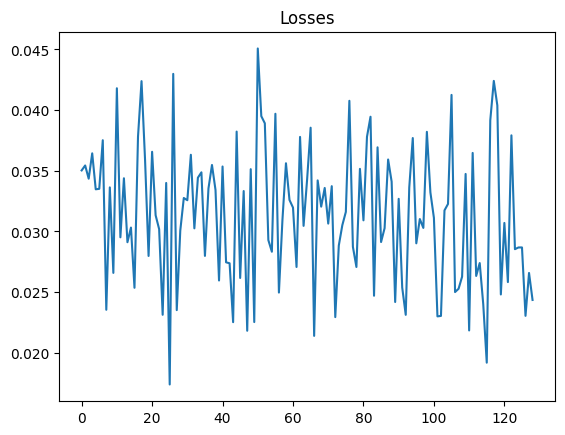

======== Epoch 2 / 5 ========
  Batch    40  of    129.    Elapsed: 0:01:01.
  Batch    80  of    129.    Elapsed: 0:02:02.
  Batch   120  of    129.    Elapsed: 0:03:04.


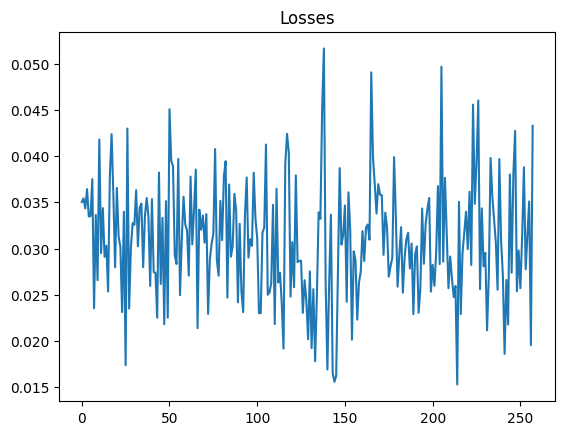

======== Epoch 3 / 5 ========
  Batch    40  of    129.    Elapsed: 0:01:02.
  Batch    80  of    129.    Elapsed: 0:02:04.
  Batch   120  of    129.    Elapsed: 0:03:06.


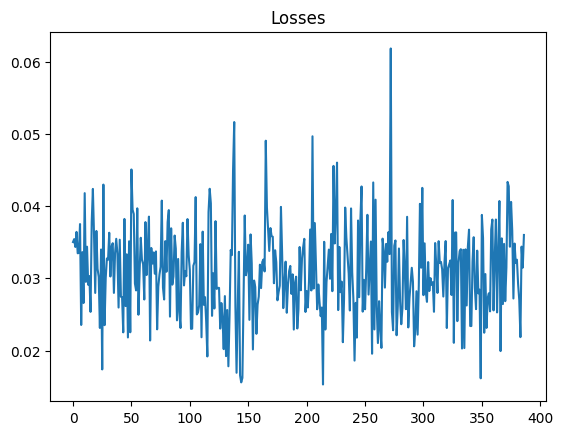

======== Epoch 4 / 5 ========
  Batch    40  of    129.    Elapsed: 0:01:02.
  Batch    80  of    129.    Elapsed: 0:02:04.
  Batch   120  of    129.    Elapsed: 0:03:06.


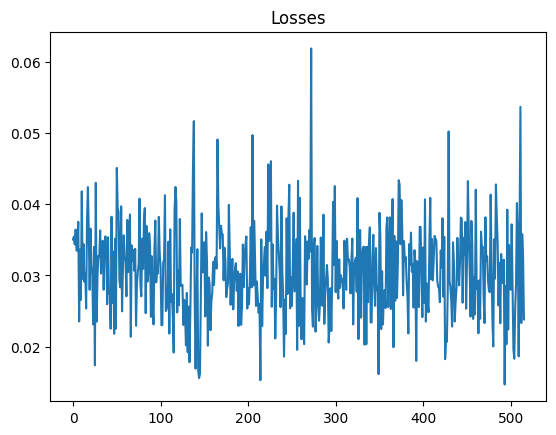

======== Epoch 5 / 5 ========
  Batch    40  of    129.    Elapsed: 0:01:02.


wandb: Ctrl + C detected. Stopping sweep.


In [72]:
wandb.agent(sweep_id,function=train)

In [73]:
wandb.finish()

avg_train_loss,█▁▂▁
avg_val_loss,▆▁█▄
train_batch_loss,▂▃▅▂▄▅▄▄▂▅▂▆▃▃▆█▄▅▅▂▂▄▆▅▆▇▄▂▅▃▅▂▂▄▁▂▃▁▆▂
train_f1,▁▁▁▁
train_precision,▁▁▁▁
val_accuracy,██▁█
val_f1,▁▁▁▁
val_precision,▁▁▁▁
avg_train_loss,0.03045
avg_val_loss,0.03102
train_batch_loss,0.02092


In [81]:
import torch
import gc

torch.cuda.empty_cache()

# Call the garbage collector
gc.collect()

# Ensure CUDA is aware of the freed memory
torch.cuda.empty_cache()


In [ ]:
labels[:32].unsqueeze(0).view(-1).shape

torch.Size([64])

In [19]:
path_to_model = "/content/drive/MyDrive/nlp/model copy 6.pth"

In [27]:
from torch.utils.data import TensorDataset
from transformers import RobertaTokenizer, BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
# model = RobertaForSequenceClassification.from_pretrained(
    #     "roberta-base",
    #     num_labels = 2,
    #     output_attentions = False, # Whether the model returns attentions weights.
    #     output_hidden_states = False, # Whether the model returns all hidden-states.
    # )
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model.load_state_dict(torch.load(path_to_model))
model.to(device)

# Put model in evaluation mode
model.eval()

criterion = torch.nn.BCEWithLogitsLoss()

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X_dev:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_dev)

# convert to tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

# move to GPU
test_input_ids = input_ids.to(device)
test_attention_masks = attention_masks.to(device)
test_labels = labels.to(device)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(
               test_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = 16 # Evaluate with this batch size.
            )


total_TP = 0
total_FP = 0
total_FN = 0
total_TN = 0

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids,
                            attention_mask=b_input_mask)

    logits = outputs.logits

    loss = criterion(logits.float(), b_labels.float())

    predictions = torch.argmax(logits, dim=1).cpu()
    b_labels_vals = np.array([b[0].cpu().numpy() for b in b_labels])

    TP = ((predictions == 1) & (b_labels_vals == 1)).sum().item()
    FP = ((predictions == 1) & (b_labels_vals == 0)).sum().item()
    FN = ((predictions == 0) & (b_labels_vals == 1)).sum().item()
    TN = ((predictions == 0) & (b_labels_vals == 0)).sum().item()

    total_TP += TP
    total_FP += FP
    total_FN += FN
    total_TN += TN

accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN)
precision = total_TP / (total_TP + total_FP) if total_TP + total_FP > 0 else 0
recall = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
<ipython-input-27-0e5fc723bdab>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_i

KeyboardInterrupt: 

In [29]:
from torch.utils.data import TensorDataset

# load model

# Put model in evaluation mode
model.eval()

criterion = torch.nn.BCEWithLogitsLoss()

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X_dev:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
dev_data_labelled = dev_data_shuffled['label']
labels = torch.tensor(y_dev)

# convert to tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

# move to GPU
test_input_ids = input_ids.to(device)
test_attention_masks = attention_masks.to(device)
test_labels = labels.to(device)
test_actual_label = torch.tensor(np.array(dev_data_shuffled['label']))

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels, test_actual_label)
test_dataloader = DataLoader(
               test_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = 16 # Evaluate with this batch size.
            )


metrics = {label: {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0} for label in range(5)}

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)  # Binary labels for your task
    b_actual_label = batch[3].to(device)  # Actual label (0-4)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits

    predictions = torch.argmax(logits, dim=1).cpu()
    b_labels_vals = np.array([b[0].cpu().numpy() for b in b_labels])


    for label in range(5):
        # Filter indices for each actual label
        label_indices = (b_actual_label.cpu() == label).nonzero().squeeze()
        # Check if label_indices is a scalar (0-dimensional tensor)
        if label_indices.dim() == 0:
            # If so, check if it's not empty by seeing if it's a tensor at all
            if label_indices.nelement() == 0:
                continue  # Skip if no samples for this label
            else:
                # Make label_indices a one-element list to work with the iteration logic
                label_indices = [label_indices.item()]

        if len(label_indices) == 0:
            continue  # Skip if no samples for this label

        # Filter predictions and labels for the current actual label
        label_predictions = predictions[label_indices]
        label_b_labels = b_labels_vals[label_indices]

        # Calculate TP, FP, FN, TN
        TP = ((label_predictions == 1) & (label_b_labels == 1)).sum().item()
        FP = ((label_predictions == 1) & (label_b_labels == 0)).sum().item()
        FN = ((label_predictions == 0) & (label_b_labels == 1)).sum().item()
        TN = ((label_predictions == 0) & (label_b_labels == 0)).sum().item()

        metrics[label]['TP'] += TP
        metrics[label]['FP'] += FP
        metrics[label]['FN'] += FN
        metrics[label]['TN'] += TN

for label in metrics:
    TP = metrics[label]['TP']
    FP = metrics[label]['FP']
    FN = metrics[label]['FN']
    TN = metrics[label]['TN']

    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Metrics for Actual Label {label}:")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1_score)
    print("---")

<ipython-input-29-4a61944e33cc>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
<ipython-input-29-4a61944e33cc>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = torch.tensor(attention_masks)
<ipython-input-29-4a61944e33cc>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Metrics for Actual Label 0:
Accuracy:  0.17560975609756097
Precision:  0.0
Recall:  0
F1 Score:  0
---
Metrics for Actual Label 1:
Accuracy:  0.25
Precision:  0.0
Recall:  0
F1 Score:  0
---
Metrics for Actual Label 2:
Accuracy:  0.8461538461538461
Precision:  1.0
Recall:  0.8461538461538461
F1 Score:  0.9166666666666666
---
Metrics for Actual Label 3:
Accuracy:  0.7671232876712328
Precision:  1.0
Recall:  0.7671232876712328
F1 Score:  0.8682170542635659
---
Metrics for Actual Label 4:
Accuracy:  0.676923076923077
Precision:  1.0
Recall:  0.676923076923077
F1 Score:  0.8073394495412844
---


In [28]:
sent_lens = [len(i) for i in X_dev]
mean_length = np.mean(sent_lens)
std_dev_length = np.std(sent_lens)

print("Mean sentence length:", mean_length)
print("Standard deviation of sentence lengths:", std_dev_length)

Mean sentence length: 261.2336359292881
Standard deviation of sentence lengths: 145.70527155732617


In [29]:
from torch.utils.data import TensorDataset
import torch


# load model
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Put model in evaluation mode
model.eval()

criterion = torch.nn.BCEWithLogitsLoss()

NUMBER_OF_BINS=4


def get_bin_from_sentence_length(length, std, mean, bins=4):
    # Calculate z-score
    z = (length - mean) / std
    # Map z-score to bin
    if z < -0.675:  # 1st quartile
        return 0
    elif z < 0:  # 2nd quartile
        return 1
    elif z < 0.675:  # 3rd quartile
        return 2
    else:  # 4th quartile
        return 3


input_ids = []
attention_masks = []
para_bin_position = []

for sent in X_dev:
    encoded_dict = tokenizer.encode_plus(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=300,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

    # Assign sentence to a bin based on its length
    para_bin_position.append(get_bin_from_sentence_length(len(sent), std_dev_length, mean_length, bins=NUMBER_OF_BINS))

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
dev_data_labelled = dev_data_shuffled['label']
labels = torch.tensor(y_dev)

# convert to tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

# move to GPU
test_input_ids = input_ids.to(device)
test_attention_masks = attention_masks.to(device)
test_labels = labels.to(device)
test_bin_pos = torch.tensor(para_bin_position)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels, test_bin_pos)
test_dataloader = DataLoader(
               test_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = 16 # Evaluate with this batch size.
            )


metrics = {label: {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0} for label in range(NUMBER_OF_BINS)}

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)  # Binary labels for your task
    b_bin_pos = batch[3].to(device)  # Bin positions

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits

    # Keep predictions on the device to match with b_labels and b_bin_pos
    predictions = torch.argmax(logits, dim=1)

    for bin_idx in range(NUMBER_OF_BINS):
        bin_indices = (b_bin_pos == bin_idx).nonzero(as_tuple=False).squeeze()

        if bin_indices.numel() == 0:  # If no elements for this bin, skip to the next
            continue

        if bin_indices.dim() == 0:
            bin_indices = bin_indices.unsqueeze(0)  # Ensure bin_indices is indexable

        # Filter predictions and labels for the current bin; keeping all operations on the same device
        bin_predictions = predictions[bin_indices]
        bin_labels = b_labels[bin_indices]

        # Extract the first element from each [1,0] or [0,1] array in b_labels for comparison
        bin_labels_first_elem = bin_labels[:, 0]

        TP = ((bin_predictions == 1) & (bin_labels_first_elem == 1)).sum().item()
        FP = ((bin_predictions == 1) & (bin_labels_first_elem == 0)).sum().item()
        FN = ((bin_predictions == 0) & (bin_labels_first_elem == 1)).sum().item()
        TN = ((bin_predictions == 0) & (bin_labels_first_elem == 0)).sum().item()

        metrics[bin_idx]['TP'] += TP
        metrics[bin_idx]['FP'] += FP
        metrics[bin_idx]['FN'] += FN
        metrics[bin_idx]['TN'] += TN



print(f" Standard Deviation : {std_dev_length}, Mean Length: {mean_length}")
for label in metrics:
    TP = metrics[label]['TP']
    FP = metrics[label]['FP']
    FN = metrics[label]['FN']
    TN = metrics[label]['TN']

    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Metrics for Paragraph Length - Q{label}:")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1_score)
    print("---")

<ipython-input-29-0c765e542f4e>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
<ipython-input-29-0c765e542f4e>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = torch.tensor(attention_masks)
<ipython-input-29-0c765e542f4e>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


 Standard Deviation : 145.70527155732617, Mean Length: 261.2336359292881
Metrics for Paragraph Length - Q0:
Accuracy:  0.09037900874635568
Precision:  0.08235294117647059
Recall:  1.0
F1 Score:  0.15217391304347827
---
Metrics for Paragraph Length - Q1:
Accuracy:  0.16489361702127658
Precision:  0.09072978303747535
Recall:  0.8214285714285714
F1 Score:  0.16341030195381884
---
Metrics for Paragraph Length - Q2:
Accuracy:  0.31629392971246006
Precision:  0.08928571428571429
Recall:  0.6666666666666666
F1 Score:  0.15748031496062992
---
Metrics for Paragraph Length - Q3:
Accuracy:  0.46464646464646464
Precision:  0.10897435897435898
Recall:  0.4594594594594595
F1 Score:  0.17616580310880828
---


In [31]:
keyword_ids, unique_keywords = pd.factorize(dev_data_shuffled['keyword'])

# Create the mapping dictionary from `unique_keywords`
keyword_to_id = {keyword: idx for idx, keyword in enumerate(unique_keywords)}

len(keyword_ids), keyword_to_id

(2093,
 {'poor-families': 0,
  'migrant': 1,
  'immigrant': 2,
  'hopeless': 3,
  'refugee': 4,
  'women': 5,
  'in-need': 6,
  'homeless': 7,
  'vulnerable': 8,
  'disabled': 9})

In [32]:
from torch.utils.data import TensorDataset
import torch


# load model
model.to(device)

# Put model in evaluation mode
model.eval()

criterion = torch.nn.BCEWithLogitsLoss()


input_ids = []
attention_masks = []

for sent in X_dev:
    encoded_dict = tokenizer.encode_plus(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=300,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Concatenate list of tensors into a single tensor
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Factorize keywords to get keyword IDs and the unique keywords
keyword_ids, unique_keywords = pd.factorize(dev_data_shuffled['keyword'])
keyword_ids = torch.tensor(keyword_ids)  # Convert keyword IDs to tensor

# Convert labels to tensor
labels = torch.tensor(y_dev)

# Move tensors to the GPU
test_input_ids = input_ids.to(device)
test_attention_masks = attention_masks.to(device)
test_labels = labels.to(device)
test_keyword_ids = keyword_ids.to(device)



# Prepare the dataset and dataloader
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels, test_keyword_ids)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=16
)

# Initialize metrics dictionary
NUMBER_OF_KEYWORDS = len(unique_keywords)  # Update to use the length of unique_keywords
metrics = {keyword: {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0} for keyword in range(NUMBER_OF_KEYWORDS)}

# Loop through dataloader
for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels, b_keyword_id = [t.to(device) for t in batch]

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

    # Iterate through each unique keyword ID to calculate metrics
    for keyword_id in range(NUMBER_OF_KEYWORDS):
        keyword_indices = (b_keyword_id == keyword_id).nonzero(as_tuple=False).squeeze()

        if keyword_indices.numel() == 0:  # Skip if no samples for this keyword
            continue

        if keyword_indices.dim() == 0:
            keyword_indices = keyword_indices.unsqueeze(0)  # Make keyword_indices indexable

        # Filter predictions and labels for the current keyword ID
        keyword_predictions = predictions[keyword_indices]
        keyword_labels = b_labels[keyword_indices][:, 0]  # Assuming b_labels are binary [1, 0] arrays

        TP = ((keyword_predictions == 1) & (keyword_labels == 1)).sum().item()
        FP = ((keyword_predictions == 1) & (keyword_labels == 0)).sum().item()
        FN = ((keyword_predictions == 0) & (keyword_labels == 1)).sum().item()
        TN = ((keyword_predictions == 0) & (keyword_labels == 0)).sum().item()

        metrics[keyword_id]['TP'] += TP
        metrics[keyword_id]['FP'] += FP
        metrics[keyword_id]['FN'] += FN
        metrics[keyword_id]['TN'] += TN

# Print the metrics

for keyword_id in metrics:
    TP = metrics[keyword_id]['TP']
    FP = metrics[keyword_id]['FP']
    FN = metrics[keyword_id]['FN']
    TN = metrics[keyword_id]['TN']

    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Use keyword_id to get the actual keyword from the unique_keywords array
    actual_keyword = unique_keywords[keyword_id]

    print(f"Metrics for Keyword '{actual_keyword}':")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1_score)
    print("---")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics for Keyword 'poor-families':
Accuracy:  0.3631578947368421
Precision:  0.2014388489208633
Recall:  0.7368421052631579
F1 Score:  0.3163841807909604
---
Metrics for Keyword 'migrant':
Accuracy:  0.18446601941747573
Precision:  0.023391812865497075
Recall:  0.8
F1 Score:  0.045454545454545456
---
Metrics for Keyword 'immigrant':
Accuracy:  0.15137614678899083
Precision:  0.036458333333333336
Recall:  1.0
F1 Score:  0.07035175879396986
---
Metrics for Keyword 'hopeless':
Accuracy:  0.2764976958525346
Precision:  0.11695906432748537
Recall:  0.7692307692307693
F1 Score:  0.20304568527918782
---
Metrics for Keyword 'refugee':
Accuracy:  0.17553191489361702
Precision:  0.05063291139240506
Recall:  0.6153846153846154
F1 Score:  0.0935672514619883
---
Metrics for Keyword 'women':
Accuracy:  0.2145922746781116
Precision:  0.03314917127071823
Recall:  0.42857142857142855
F1 Score:  0.06153846153846154
---
Metrics for Keyword 'in-need':
Accuracy:  0.23008849557522124
Precision:  0.1147540

In [53]:
test_dataframe = pd.read_csv("./task4_test.tsv", sep='\t', header=None, names=['id', 'paragraph-id', 'keyword', 'countrycode', "paragraph", "pcl_or_not"])
test_dataframe

pcl_or_not = []


def tokenise_paragraph(paragraph):
  encoded_dict = tokenizer.encode_plus(
      paragraph,  # Sentence to encode.
      add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
      max_length=300,  # Pad & truncate all sentences.
      pad_to_max_length=True,
      return_attention_mask=True,  # Construct attn. masks.
      return_tensors='pt',  # Return pytorch tensors.
  )
  return encoded_dict['input_ids'].to(device), encoded_dict['attention_mask'].to(device)



# use model to predict the label for a s
def make_prediction(paragraph):
  tokenised, mask = tokenise_paragraph(paragraph)
  outputs = model(tokenised, attention_mask=mask)
  logits = outputs.logits
  print(logits)
  prediction = torch.argmax(logits, dim=1).cpu()
  return prediction


for index, row in test_dataframe.iterrows():
  prediction = make_prediction(row['paragraph']).to('cpu')[0].item()
  pcl_or_not.append(prediction)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tensor([[-0.0037,  0.0117]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-7.0689e-05,  6.6764e-03]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0012, 0.0082]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0044,  0.0142]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0073,  0.0062]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.0024, -0.0014]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0036,  0.0165]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0120,  0.0138]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0027,  0.0116]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0051,  0.0067]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0107,  0.0114]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.0104, -0.0040]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.0092, -0.0011]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0142,  0.0111]], device='cuda:0', grad_fn=<Add

In [56]:
filename = "test.txt"
# Write the array to the file, each element on a new line
with open(filename, "w") as file:
    for element in pcl_or_not:
        file.write(f"{element}\n")

In [57]:
file_path = "./dontpatronizeme_pcl.tsv"
train_filepath = "./train_semeval_parids-labels.csv"
dev_filepath = "./dev_semeval_parids-labels.csv"

df = pd.read_csv(file_path, sep='\t', header=None, names=['id', 'paragraph-id', 'keyword', 'countrycode', "paragraph", "label"])
df_filtered = df[df['paragraph'].notna()]

train_df = pd.read_csv(train_filepath)
dev_df = pd.read_csv(dev_filepath)

train_data = df_filtered[df_filtered['id'].isin(train_df['par_id'])]
dev_data = df_filtered[df_filtered['id'].isin(dev_df['par_id'])]

# get indexes of labels 0 and 1
train_data_0 = train_data[train_data['label'] <= 1]
train_data_1 = train_data[train_data['label'] > 1]
# get 10% of the training data indexes

dev_data_shuffled = dev_data

X_dev = dev_data_shuffled['paragraph'].to_numpy()

In [60]:
pcl_or_not_dev = []
for para in X_dev:
  prediction = make_prediction(para).to('cpu')[0].item()
  pcl_or_not_dev.append(prediction)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tensor([[0.0010, 0.0038]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0123,  0.0015]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0091,  0.0155]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0047, 0.0056]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.0088, -0.0005]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0043, 0.0009]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0065,  0.0115]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0066,  0.0017]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.0019, -0.0029]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0033,  0.0099]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.0021, -0.0006]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0020,  0.0036]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0076,  0.0040]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0055,  0.0056]], device='cuda:0', grad_fn=<AddmmBackward0>

In [61]:
  filename = "dev.txt"
# Write the array to the file, each element on a new line
with open(filename, "w") as file:
    for element in pcl_or_not_dev:
        file.write(f"{element}\n")